In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer


from typing import Tuple
import sys

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Golem Bootcamp 2022 - Tips & Tricks
_15.11.2022_

Interesuje nas dzisiaj tematyka **danych**. Będziemy się starali poprawić **dane**, na których trenujemy zostając przy tym samym **klasyfikatorze**, aby poprawić wynik końcowy.

### Na czym dzisiaj operujemy?
Zbiór danych o pacjentach, którzy mają choroby układu krążenia.

SOURCE: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

<img src="imgs/dataset-cover.jpg">


### Data Loading

In [119]:
train_data = pd.read_csv('data/train_data.csv')
test_features = pd.read_csv('data/test_features.csv')

### First look

In [120]:
train_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,lifestyle,is_cardio_ill
0,12611,21805,male,172.0,90.0,100,80,normal,normal,active,0
1,91034,22751,female,156.0,100.0,150,100,normal,normal,active,0
2,25237,18944,female,160.0,60.0,120,80,normal,normal,active,0
3,27159,18869,female,158.0,96.0,130,80,way above normal,normal,active,0
4,34101,21233,female,151.0,100.0,130,80,way above normal,way above normal,active,0


In [121]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30175 entries, 0 to 30174
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30175 non-null  int64  
 1   age            30175 non-null  int64  
 2   gender         29285 non-null  object 
 3   height         29608 non-null  float64
 4   weight         29028 non-null  float64
 5   ap_hi          30175 non-null  int64  
 6   ap_lo          30175 non-null  int64  
 7   cholesterol    30175 non-null  object 
 8   gluc           30175 non-null  object 
 9   lifestyle      25095 non-null  object 
 10  is_cardio_ill  30175 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 2.5+ MB


In [122]:
train_data['gender'].value_counts()

female    19124
male      10161
Name: gender, dtype: int64

In [123]:
train_data['cholesterol'].value_counts()

normal              24595
above normal         3471
way above normal     2109
Name: cholesterol, dtype: int64

In [124]:
train_data['gluc'].value_counts()

normal              26322
above normal         1938
way above normal     1915
Name: gluc, dtype: int64

In [125]:
train_data['lifestyle'].value_counts()

active                     21562
smoker,active               1571
smoker,alcoholic,active      762
alcoholic,active             664
smoker                       283
alcoholic                    132
smoker,alcoholic             121
Name: lifestyle, dtype: int64

### Quickest submission on earth

In [126]:
# Helpers

LABEL_COL = "is_cardio_ill"
RANDOM_STATE = 42



def make_train_valid_split(train_data: pd.DataFrame, test_size: int = 100) -> Tuple[pd.DataFrame]:
    
    """
    Makes train test split based on the feature column and dataframe provided
    """
    
    features, labels = train_data.drop(LABEL_COL, axis=1), train_data[LABEL_COL]
    train_X, validation_X, train_y, validation_y = \
                train_test_split(features, labels, test_size=test_size, random_state=RANDOM_STATE)
    
    return train_X, validation_X, train_y, validation_y

In [127]:
# Model od Bartka
class CoolModel():
    def __init__(self):
        pass

    def fit(self, x, y):
        pass

    def predict(self, x):
        return [0 for _ in range(len(x))]

In [128]:
train_X, validation_X, train_y, validation_y = make_train_valid_split(train_data)
model = CoolModel()
model.fit(train_X, train_y)
predictions = model.predict(validation_X)

acc = accuracy_score(validation_y, predictions)
make_percents = lambda val: 100 * round(val, 2)

print(f"Accuracy on a dummiest model: {make_percents(acc)} %")

Accuracy on a dummiest model: 90.0 %


### Czy rozwiązaliśmy zadanie?

Not really... 🥴🥴🥴

ROC score: 0.5


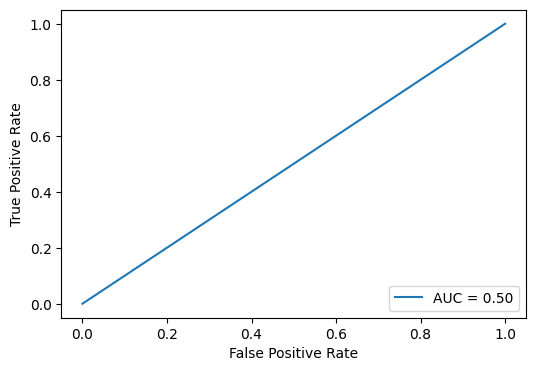

In [129]:
def evaluate_with_roc(validations, predictions):

    print(f"ROC score: {roc_auc_score(validations, predictions)}")
    plt.rcParams['figure.figsize'] = 6, 4
    fpr, tpr, thresholds = roc_curve(validations, predictions)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()
    
evaluate_with_roc(validation_y, predictions)

### No dobra, to teraz potrenujmy jak się należy

In [130]:

def train_logreg_classifier(train_X, train_y):
    try:
        clf = LogisticRegression()
        clf.fit(train_X, train_y)
        return clf
    except:
        print(sys.exc_info()[0:2])
    

In [131]:
train_logreg_classifier(train_X, train_y)

(<class 'ValueError'>, ValueError("could not convert string to float: 'male'"))


Co zaobserwowaliśmy:
* Nie możemy przekonwertować do floata - nasz algorytm potrzebuje liczb

Co na to możemy poradzić (najprościej)?

* Wywalmy wszystkie kolumny, które nie są liczbowe

In [132]:
train_data.dtypes

id                 int64
age                int64
gender            object
height           float64
weight           float64
ap_hi              int64
ap_lo              int64
cholesterol       object
gluc              object
lifestyle         object
is_cardio_ill      int64
dtype: object

In [133]:
COLUMNS_TO_REMOVE = ["id", "gender", "cholesterol", "gluc", "lifestyle"]
train_data_tiny_raw = train_data.drop(COLUMNS_TO_REMOVE, axis=1)

Obserwacje?
- W naszym datasecie mamy opuszczone wartości
Co najprościej możemy zrobić?
- Wywalić wiersze z opuszczonymi wartościami

ROC score: 0.49411764705882355


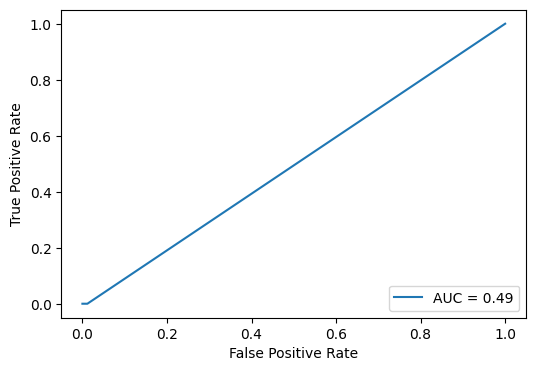

In [134]:
train_data_tiny = train_data_tiny_raw.dropna()

train_X, valid_X, train_y, valid_y = make_train_valid_split(train_data_tiny)
clf = train_logreg_classifier(train_X, train_y)

predictions = clf.predict(valid_X)
evaluate_with_roc(valid_y, predictions)

In [135]:
# print(f"Accuracy: {make_percents(accuracy)}%")

### Common sense cleaning

In [136]:
train_X, valid_X, train_y, valid_y = make_train_valid_split(train_data_tiny, test_size=1000)

print(f"Minimal High pressure is: {train_X.ap_hi.min()}")
print(f"Maximum High pressure is : {train_X.ap_hi.max()}")

print(f"Minimal Low pressure is: {train_X.ap_lo.min()}")
print(f"Maximal Low pressure is: {train_X.ap_lo.max()}")

Minimal High pressure is: -115
Maximum High pressure is : 13010
Minimal Low pressure is: 0
Maximal Low pressure is: 11000


In [137]:
def make_common_sense_cleaning(features):
    
    features['ap_hi'] = np.abs(features['ap_hi'])
    features['ap_lo'] = np.abs(features['ap_lo'])
    
    # removing invalid features
    features.loc[(features['ap_hi'] < MAX_SYST) & (features['ap_hi'] > MIN_SYST)]['ap_hi'] = np.nan
    features.loc[(features['ap_hi'] < MAX_SYST) & (features['ap_hi'] > MIN_SYST)]['ap_hi'] = np.nan

    features = features[(features['ap_hi'] < MAX_SYST) & (features['ap_hi'] > MIN_SYST)]
    features = features[(features['ap_lo'] < MAX_DIAST) & (features['ap_lo'] > MIN_DIAST)]
#     train_y = train_y[features.index]

    features['ap_hi'].plot.hist(edgecolor="black", grid=True)
    features['ap_lo'].plot.hist(edgecolor="black", grid=True)
    
    return features

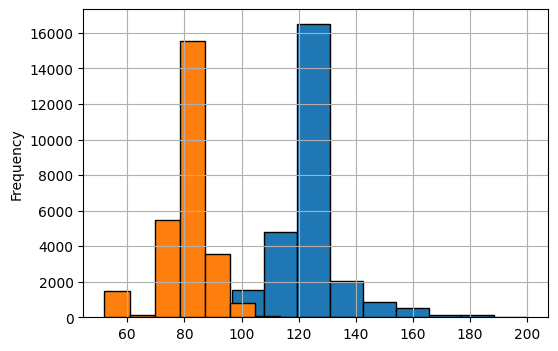

In [138]:
train_X['ap_hi'] = np.abs(train_X['ap_hi'])
train_X['ap_lo'] = np.abs(train_X['ap_lo'])

MAX_SYST = 210
MAX_DIAST = 150
MIN_SYST = 80
MIN_DIAST = 50

train_X = train_X[(train_X['ap_hi'] < MAX_SYST) & (train_X['ap_hi'] > MIN_SYST)]
train_X = train_X[(train_X['ap_lo'] < MAX_DIAST) & (train_X['ap_lo'] > MIN_DIAST)]
train_y = train_y[train_X.index]

train_X['ap_hi'].plot.hist(edgecolor="black", grid=True)
train_X['ap_lo'].plot.hist(edgecolor="black", grid=True)

### the same for validation set
valid_X['ap_hi'] = np.abs(valid_X['ap_hi'])
valid_X['ap_lo'] = np.abs(valid_X['ap_lo'])

valid_X = valid_X[(valid_X['ap_hi'] < MAX_SYST) & (valid_X['ap_hi'] > MIN_SYST)]
valid_X = valid_X[(valid_X['ap_lo'] < MAX_DIAST) & (valid_X['ap_lo'] > MIN_DIAST)]
valid_y = valid_y[valid_X.index]

ROC score: 0.5488667782305006


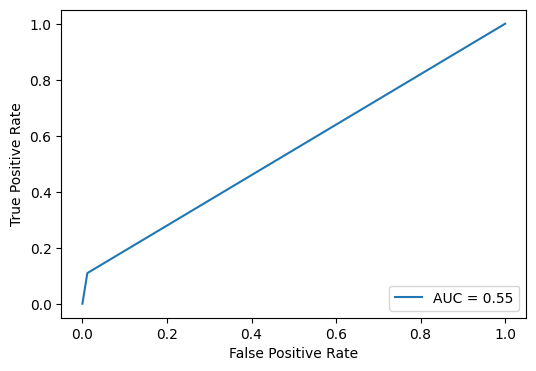

In [139]:
clf = train_logreg_classifier(train_X, train_y)

predictions = clf.predict(valid_X)
evaluate_with_roc(valid_y, predictions)

### Categorical features - encoding

In [140]:
### Adding more data is always a good strategy
train_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,lifestyle,is_cardio_ill
0,12611,21805,male,172.0,90.0,100,80,normal,normal,active,0
1,91034,22751,female,156.0,100.0,150,100,normal,normal,active,0
2,25237,18944,female,160.0,60.0,120,80,normal,normal,active,0
3,27159,18869,female,158.0,96.0,130,80,way above normal,normal,active,0
4,34101,21233,female,151.0,100.0,130,80,way above normal,way above normal,active,0


### Ordinal Encoding

Zakodujmy liczbami te wartości, których stopień nasilenia możemy łatwo zidentyfikować

* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html">OrdinalEncoder</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder">OneHotEncoder</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder">LabelEncoder</a>

In [141]:
train_data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,lifestyle,is_cardio_ill
0,12611,21805,male,172.0,90.0,100,80,normal,normal,active,0
1,91034,22751,female,156.0,100.0,150,100,normal,normal,active,0
2,25237,18944,female,160.0,60.0,120,80,normal,normal,active,0
3,27159,18869,female,158.0,96.0,130,80,way above normal,normal,active,0
4,34101,21233,female,151.0,100.0,130,80,way above normal,way above normal,active,0
...,...,...,...,...,...,...,...,...,...,...,...
30170,80030,20991,male,165.0,63.0,150,1000,normal,normal,active,0
30171,46614,17490,male,152.0,65.0,130,90,normal,normal,active,0
30172,59442,14653,female,163.0,70.0,110,70,normal,normal,active,0
30173,25682,20528,female,158.0,63.0,120,90,normal,normal,active,0


In [142]:
CATEG_COLUMNS = ['cholesterol', 'gluc', 'lifestyle', 'gender', 'is_cardio_ill']
full_categorical = train_data[CATEG_COLUMNS]

# train_X_cat, valid_X_cat, train_y_cat, valid_y_cat = full_categorical[]
train_categorical = full_categorical.iloc[train_X.index]
valid_categorical = full_categorical.iloc[valid_X.index]

train_X_cat, train_y_cat = train_categorical.drop(LABEL_COL, axis=1), train_categorical[LABEL_COL]
valid_X_cat, valid_y_cat = valid_categorical.drop(LABEL_COL, axis=1), train_categorical[LABEL_COL]

In [143]:



ORDINAL_COLUMNS = ['cholesterol', 'gluc']

oe = OrdinalEncoder(categories=[['normal', 'above normal', 'way above normal'], ['normal', 'above normal', 'way above normal']])

oe.fit(train_X_cat[ORDINAL_COLUMNS])

# The same encoder
ord_encoded_train = oe.transform(train_X_cat[ORDINAL_COLUMNS])
train_X_cat[ORDINAL_COLUMNS] = ord_encoded_train

ord_encoded_val = oe.transform(valid_X_cat[ORDINAL_COLUMNS])
valid_X_cat[ORDINAL_COLUMNS] = ord_encoded_val


In [144]:
valid_X_cat.head()

,cholesterol,gluc,lifestyle,gender
18939,1.0,1.0,"alcoholic,active",male
28923,0.0,1.0,"smoker,alcoholic,active",male
18207,0.0,0.0,"smoker,active",male
9673,0.0,0.0,active,female
26743,2.0,2.0,NaN,female


### One Hot Encoding

##### Step 1 - making columns from preprocessing

In [145]:
def encode_lifestyle(lifestyle_row) -> dict:
    
    lifestyle_dict = {
        "is_active": 0,
        "smoker": 0,
        "alcohol_consumer": 0
    }
    
    if lifestyle_row is not np.nan:
        values = lifestyle_row.split(',')

        if 'active' in values:
            lifestyle_dict['is_active'] = 1

        if 'smoker' in values:
            lifestyle_dict['smoker'] = 1

        if 'alcoholic' in values:
            lifestyle_dict['alcohol_consumer'] = 1
    
    return lifestyle_dict

In [146]:
# doing it on train dataset
dicts_train = train_X_cat.lifestyle.apply(encode_lifestyle)
lifestyle_df_train = pd.DataFrame(list(dicts_train.values), index=dicts_train.index)
train_X_cat.drop('lifestyle', axis=1, inplace=True)
train_X_cat = pd.concat([train_X_cat, lifestyle_df_train], axis=1)

# the same for validation
dicts_val = valid_X_cat.lifestyle.apply(encode_lifestyle)
lifestyle_df_val = pd.DataFrame(list(dicts_val.values), index=dicts_val.index)
valid_X_cat.drop('lifestyle', axis=1, inplace=True)
valid_X_cat = pd.concat([valid_X_cat, lifestyle_df_val], axis=1)

##### Step 2 - transforming them using OneHotEncoder

In [147]:
GENDER_COL = 'gender'

train_gender_df = pd.get_dummies(train_X_cat[GENDER_COL])
train_X_cat = train_X_cat.drop(GENDER_COL, axis=1)
train_X_cat = pd.concat([train_X_cat, train_gender_df], axis=1)
train_gender_df

valid_gender_df = pd.get_dummies(valid_X_cat[GENDER_COL])
valid_X_cat = valid_X_cat.drop(GENDER_COL, axis=1)
valid_gender_df = pd.concat([valid_X_cat, valid_gender_df], axis=1)

In [148]:
valid_X_cat = valid_gender_df

In [149]:
valid_X

,age,height,weight,ap_hi,ap_lo
18939,18385,170.0,75.0,120,80
28923,17288,170.0,78.0,120,80
18207,21263,166.0,83.0,120,80
9673,16840,162.0,66.0,100,70
26743,19823,165.0,65.0,120,80
...,...,...,...,...,...
14065,19525,156.0,59.0,120,80
9233,21782,174.0,73.0,120,70
3922,21020,155.0,76.0,110,70
17926,16657,157.0,42.0,120,80


### Combining datasets and exploring results

In [150]:
# train_X_cat = train_X_cat.drop('')
train_X = pd.concat([train_X_cat, train_X], axis=1)
valid_X = pd.concat([valid_X_cat, valid_X], axis=1)

In [151]:
train_X.head()

,cholesterol,gluc,is_active,smoker,alcohol_consumer,female,male,age,height,weight,ap_hi,ap_lo
8807,0.0,0.0,1,0,0,1,0,19812,169.0,61.0,141,90
27087,0.0,2.0,1,0,0,1,0,20361,151.0,65.0,120,80
25561,1.0,0.0,1,1,1,0,0,21878,165.0,66.0,120,80
20616,0.0,0.0,1,1,1,1,0,20498,164.0,77.0,120,70
2801,0.0,0.0,0,0,0,0,1,19897,160.0,60.0,120,80


In [152]:
valid_X.head()

,cholesterol,gluc,is_active,smoker,alcohol_consumer,female,male,age,height,weight,ap_hi,ap_lo
18939,1.0,1.0,1,0,1,0,1,18385,170.0,75.0,120,80
28923,0.0,1.0,1,1,1,0,1,17288,170.0,78.0,120,80
18207,0.0,0.0,1,1,0,0,1,21263,166.0,83.0,120,80
9673,0.0,0.0,1,0,0,1,0,16840,162.0,66.0,100,70
26743,2.0,2.0,0,0,0,1,0,19823,165.0,65.0,120,80


In [153]:
train_X = train_X.dropna()
valid_X = valid_X.dropna()

train_y = train_y[train_X.index]
valid_y = valid_y[valid_y.index]

ROC score: 0.5572613504074505


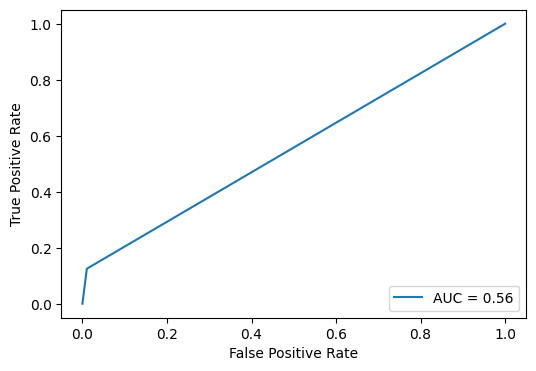

In [154]:
clf = train_logreg_classifier(train_X, train_y)

predictions = clf.predict(valid_X)
evaluate_with_roc(valid_y, predictions)

### Scaling

- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">Min Max Scaler</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">Standard Scaler</a>

<img src='imgs/scaling.png' width=600 height=800>

In [173]:
train_columns = train_X.columns
valid_columns = valid_X.columns

scaler = MinMaxScaler()
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X), columns=train_columns)
valid_X = pd.DataFrame(scaler.transform(valid_X), columns=valid_columns)

clf = train_logreg_classifier(train_X, train_y)

predictions = clf.predict(valid_X)
evaluate_with_roc(valid_y, predictions)

# preds_logreg = log_reg_clf.predict(valid_X)
# evaluate_with_roc(valid_y, preds_logreg)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [156]:
train_X

,cholesterol,gluc,is_active,smoker,alcohol_consumer,female,male,age,height,weight,ap_hi,ap_lo
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.696065,0.797203,0.295858,0.486957,0.431818
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.738839,0.671329,0.319527,0.304348,0.318182
2,0.5,0.0,1.0,1.0,1.0,0.0,0.0,0.857032,0.769231,0.325444,0.304348,0.318182
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.749513,0.762238,0.390533,0.304348,0.204545
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.702688,0.734266,0.289941,0.304348,0.318182
...,...,...,...,...,...,...,...,...,...,...,...,...
27090,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.342267,0.769231,0.313609,0.304348,0.318182
27091,1.0,0.5,1.0,1.0,0.0,0.0,1.0,0.725282,0.769231,0.473373,0.739130,0.545455
27092,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.688118,0.734266,0.349112,0.304348,0.204545
27093,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.735723,0.832168,0.402367,0.347826,0.204545


### Imputation

- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html">Simple Imputer</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html">KNN Imputer</a>

In [157]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

ROC score: 0.5828588838766006


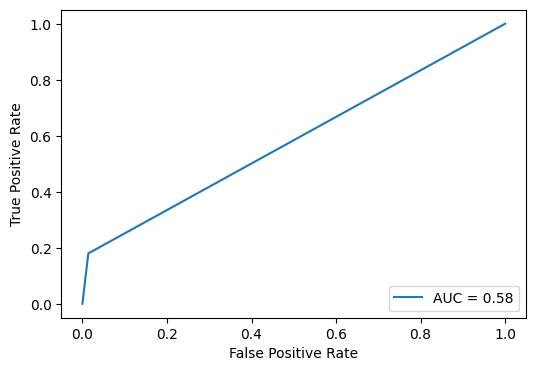

In [158]:
mean_imputer.fit(train_X)
train_X = mean_imputer.transform(train_X)
valid_X = mean_imputer.transform(valid_X)

clf = train_logreg_classifier(train_X, train_y)

predictions = clf.predict(valid_X)
evaluate_with_roc(valid_y, predictions)

#### Różne typy wartości opuszczonych
- <a href="https://bookdown.org/rwnahhas/RMPH/mi-mechanisms.html">MAR MNAR MVAR</a>

### Weighting logits with sklearn

**Cross entropy loss** (log-loss) with class weights
$$
J(\theta) = -\sum_{i}\bigl[w_0*y^{(i)}\log(h_\theta(x^{(i)})) + w_1*(1-y^{(i)})\log(1-h_\theta(x^{(i)}))\bigr]
$$

$$
w_j = nSamples / (nClasses * nSamples_j), j = {0, 1}
$$

In [159]:
def train_logreg_classifier(train_X, train_y, weighted=False):
    try:
        weight_setting = "balanced" if weighted else None
        clf = LogisticRegression(class_weight=weight_setting)
        clf.fit(train_X, train_y)
        return clf
    except:
        print(sys.exc_info()[0:2])

ROC score: 0.7402184589639116


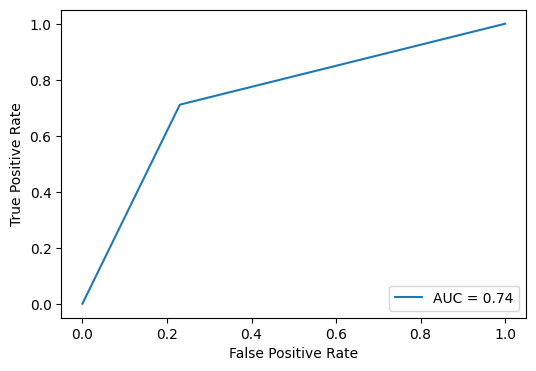

In [160]:
clf = train_logreg_classifier(train_X, train_y, weighted=True)

predictions = clf.predict(valid_X)
evaluate_with_roc(valid_y, predictions)

### Hyperparameter search

- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html" >RandomizedSearchCV</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" >GridSearchCV</a>

In [167]:
param_map = {
    'C': [1, 10, 20, 50, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [i / 5 for i in range(6)],
    'solver': ['saga']
}

searcher = RandomizedSearchCV(clf, param_distributions=param_map, scoring='roc_auc')
searcher.fit(train_X, train_y)

RandomizedSearchCV(estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': [1, 10, 20, 50, 100],
                                        'l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8,
                                                     1.0],
                                        'penalty': ['elasticnet'],
                                        'solver': ['saga']},
                   scoring='roc_auc')

In [168]:
best_clf = searcher.best_estimator_

ROC score: 0.7441247089639116


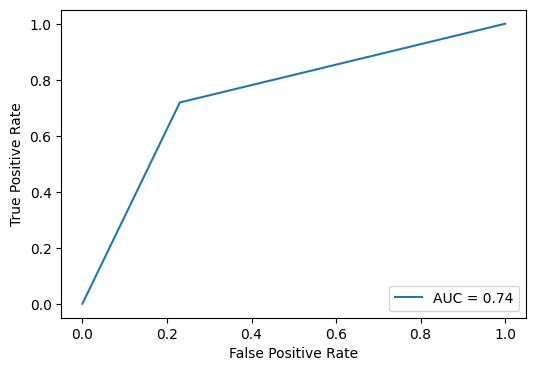

In [169]:
best_preds = best_clf.predict(valid_X)
evaluate_with_roc(valid_y, best_preds)

# Podsumujmy

- Zaczęliśmy od surowego datasetu, a po drodze zaaplikowaliśmy:
    - Kodowanie kategoryczne
    - Skalowanie atrybutów
    - Wystroiliśmy hiperparametry
- Dane zazwyczaj nie są piękne i musimy je wyczyścić i przygotować do trenowania
- Dobrze jest zaczynać od najgłupszego modela, a stopniowo go ulepszać
- Szybka ewaluacja daje swoje plony

Data is messy, cleaning it is the path to the better submissions
- We start with the worst model possible and improve it over time
- Quick evaluation is helpful

### Zadanie domowe

- Pobawić się z danymi w konkursie bootcampowym na Kaggle'u